## 计算材料的EOS曲线

### 计算材料的平衡晶格常数和黏附能

1. 创建一系列不同晶格常数的晶体, 此处以Al为例子
2. 使用EAM势函数计算零点能量
3. 绘制曲线

[参考数值见此处](https://sites.google.com/site/eampotentials/Al)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdapy as mp
from mdapy.plot.pltset import pltset, cm2inch
mp.init('cpu')

[Taichi] version 1.2.0, llvm 10.0.0, commit f189fd79, win, python 3.8.13
[Taichi] Starting on arch=x64


In [2]:
def get_enegy_lattice(lattice_constant, potential):
    x, y, z = 3, 3, 3
    FCC = mp.LatticeMaker(lattice_constant, "FCC", x, y, z) # 建立FCC晶体
    FCC.compute()
    neigh = mp.Neighbor(FCC.pos, FCC.box, potential.rc, max_neigh=150) # 建立邻域
    neigh.compute()
    Cal = mp.Calculator(
            potential,
            ["Al"],
            np.ones(FCC.pos.shape[0], dtype=np.int32),
            neigh.verlet_list,
            neigh.distance_list,
            neigh.neighbor_number,
            FCC.pos,
            [1, 1, 1],
            FCC.box,
        ) # 计算 Al 晶体的能量
    Cal.compute()
    return Cal.energy.mean()

In [3]:
%%time
eos = []
lattice_constant = 4.05
potential = mp.EAM("Al_DFT.eam.alloy")
for scale in np.arange(0.9, 1.15, 0.01):
    energy = get_enegy_lattice(lattice_constant*scale, potential)
    eos.append([scale*lattice_constant, energy])
    
eos = np.array(eos)

CPU times: total: 37.8 s
Wall time: 36 s


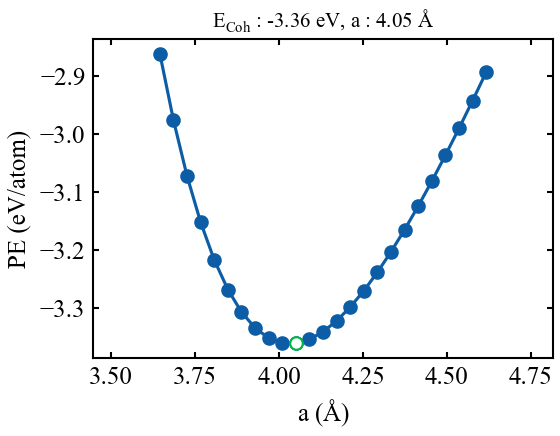

In [4]:
fig = plt.figure(figsize=(cm2inch(10), cm2inch(7)), dpi=150)
plt.subplots_adjust(bottom=0.18, top=0.95, left=0.2, right=0.98)


plt.plot(eos[:,0], eos[:,1], 'o-')

e_coh = eos[:,1].min()
a_equi = eos[np.argmin(eos[:, 1]), 0]

plt.plot([a_equi], [e_coh], 'o', mfc='white')

plt.title(r'$\mathregular{E_{Coh}}$ : %.2f eV, a : %.2f $\mathregular{\AA}$' % (e_coh, a_equi), fontsize=10)

plt.xlim(eos[0,0]-0.2, eos[-1,0]+0.2)
plt.xlabel("a ($\mathregular{\AA}$)")
plt.ylabel(r"PE (eV/atom)")
ax = plt.gca()
plt.show()